# Setting kaggle

In [0]:
# to upload files
from google.colab import files

# install Kaggle library
# !pip list
# !pip install -q kaggle

In [2]:
# upload kaggle API key file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Libraries

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten

from PIL import Image
import requests
from io import BytesIO

import json
import zipfile

from datetime import datetime
from tqdm import tqdm, auto
import shutil
import os
import gc
import warnings
warnings.filterwarnings("ignore")

# Load Data

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (PNEUMONIA/NORMAL). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [5]:
# download dataset <owner>/<dataset-name>
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

 99% 2.27G/2.29G [00:47<00:00, 77.1MB/s]
100% 2.29G/2.29G [00:47<00:00, 51.7MB/s]


In [6]:
with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zipimg:
  zipimg.extractall()

base_dir = os.getcwd()
test_img_dir = os.path.join(base_dir, 'chest_xray/test')
train_img_dir = os.path.join(base_dir, 'chest_xray/train')
val_img_dir = os.path.join(base_dir, 'chest_xray/val')

for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  display(img_dir)
  for group_img_dir in os.listdir(img_dir):
    print(f'{group_img_dir} : {len(os.listdir(os.path.join(img_dir, group_img_dir)))} samples')

'/content/chest_xray/test'

NORMAL : 234 samples
PNEUMONIA : 390 samples


'/content/chest_xray/train'

NORMAL : 1341 samples
PNEUMONIA : 3875 samples


'/content/chest_xray/val'

NORMAL : 8 samples
PNEUMONIA : 8 samples


# EDA

In [0]:
NB_TEST_SAMPLES_N = 234
NB_TEST_SAMPLES_P = 390
NB_TEST_SAMPLES = NB_TEST_SAMPLES_N + NB_TEST_SAMPLES_P
NB_TRAIN_SAMPLES_N = 1341
NB_TRAIN_SAMPLES_P = 3875
NB_TRAIN_SAMPLES = NB_TRAIN_SAMPLES_N + NB_TRAIN_SAMPLES_P
NB_VAL_SAMPLES_N = 8
NB_VAL_SAMPLES_P = 8
NB_VAL_SAMPLES = NB_VAL_SAMPLES_N + NB_VAL_SAMPLES_P

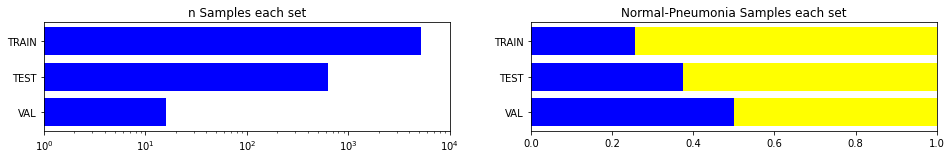

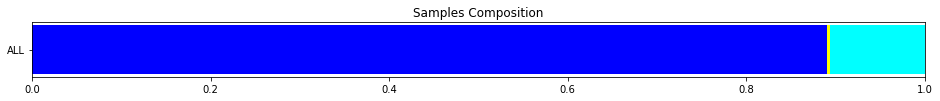

In [42]:
#@title code for samples composition
fig = plt.figure(figsize=(16,2))

ax = fig.add_subplot(1,2,1)
ax.barh(['VAL'], [NB_VAL_SAMPLES], color='#0000ff')
ax.barh(['TEST'], [NB_TEST_SAMPLES], color='#0000ff')
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES], color='#0000ff')
ax.set_xscale('log')
ax.set_xlim((1,1e4))
ax.set_title('n Samples each set');

ax = fig.add_subplot(1,2,2)
ax.barh(['VAL'], [NB_VAL_SAMPLES_N/NB_VAL_SAMPLES], color='#0000ff')
ax.barh(['VAL'], [NB_VAL_SAMPLES_P/NB_VAL_SAMPLES], color='#ffff00',
        left=[NB_VAL_SAMPLES_N/NB_VAL_SAMPLES])
ax.barh(['TEST'], [NB_TEST_SAMPLES_N/NB_TEST_SAMPLES], color='#0000ff')
ax.barh(['TEST'], [NB_TEST_SAMPLES_P/NB_TEST_SAMPLES], color='#ffff00', 
        left=[NB_TEST_SAMPLES_N/NB_TEST_SAMPLES])
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES], color='#0000ff')
ax.barh(['TRAIN'], [NB_TRAIN_SAMPLES_P/NB_TRAIN_SAMPLES], color='#ffff00', 
        left=[NB_TRAIN_SAMPLES_N/NB_TRAIN_SAMPLES])
ax.set_xlim((0,1))
ax.set_title('Normal-Pneumonia Samples each set');

fig = plt.figure(figsize=(16,1))
ax = fig.add_subplot(1,1,1)
NB_TOTAL_SAMPLES = NB_TEST_SAMPLES + NB_TRAIN_SAMPLES + NB_VAL_SAMPLES
ax.barh(['ALL'], [NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES], color='#0000ff')
ax.barh(['ALL'], [NB_VAL_SAMPLES/NB_TOTAL_SAMPLES], color='#ffff00',
        left=[NB_TRAIN_SAMPLES/NB_TOTAL_SAMPLES])
ax.barh(['ALL'], [NB_TEST_SAMPLES/NB_TOTAL_SAMPLES], color='#00ffff',
        left=[(NB_TRAIN_SAMPLES+NB_VAL_SAMPLES)/NB_TOTAL_SAMPLES])
ax.set_xlim((0,1))
ax.set_title('Samples Composition');

- seems Validation set too small to validate training. restructure train, val, test seems worthed

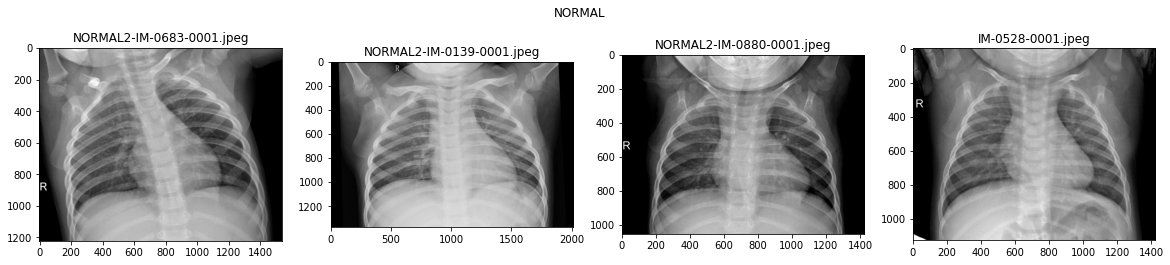

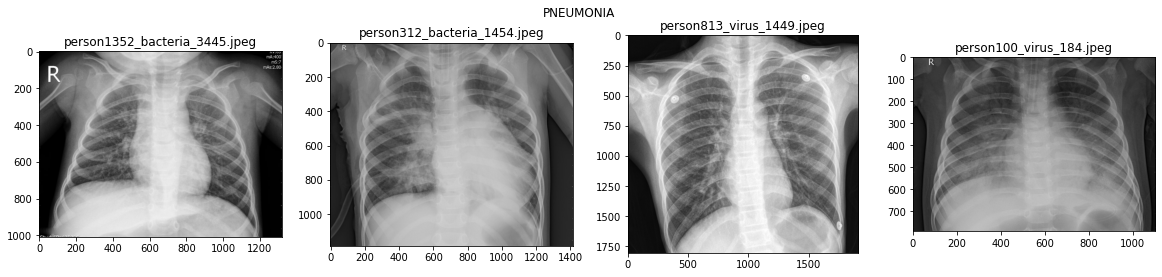

In [0]:
#@title code for show image

img_normal = []
img_pneumonia = []
for img_dir in [test_img_dir, train_img_dir, val_img_dir]:
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'NORMAL')):
    for filename in filenames:
        img_normal.append(os.path.join(dirname, filename))
  for dirname, _, filenames in os.walk(os.path.join(img_dir, 'PNEUMONIA')):
    for filename in filenames:
        img_pneumonia.append(os.path.join(dirname, filename))

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("NORMAL")
for i, j in enumerate(np.random.randint(len(img_normal), size=4).tolist()):
  ax[i].imshow(load_img(img_normal[j]))
  ax[i].set_title(img_normal[j].split('/')[-1]);

fig, ax = plt.subplots(1,4, figsize=(20, 4))
ax = ax.flatten()
plt.suptitle("PNEUMONIA")
for i, j in enumerate(np.random.randint(len(img_pneumonia), size=4).tolist()):
  ax[i].imshow(load_img(img_pneumonia[j]))
  ax[i].set_title(img_pneumonia[j].split('/')[-1]);

From the pictures, I can tell you there are differences in the rib cage shape of the patient who has pneumonia compared to normal chest.
- Somehow the x-ray return more clear image in normal person and foggy image in infected.
- Also, normal chest is relatively symetric between the right and the left part.

# Data Preparation

- resize
- ImageDataGenerator might causes "bleeding" and crop important feature

# Data Generator

ImageDataGenerator

In [0]:
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 20

In [0]:
train_datagen = ImageDataGenerator(
                   rescale=1./255,
                   rotation_range=10,  # degrees
                   zoom_range=0.15,
                   width_shift_range=0.15,  # per cent width
                   height_shift_range=0.15,  # per cent height
                   horizontal_flip=False,
                   vertical_flip=False,
                   shear_range=0.2,
                   )

train_generator = train_datagen.flow_from_directory(
                                   train_img_dir,
                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                   batch_size=BATCH_SIZE,
                                   class_mode='binary',
                                   )

val_generator = ImageDataGenerator(rescale=1./255)\
                    .flow_from_directory(
                        val_img_dir,
                         target_size=(IMG_WIDTH, IMG_HEIGHT),
                         batch_size=BATCH_SIZE,
                         class_mode='binary',
                         )

test_generator = ImageDataGenerator(rescale=1./255)\
                      .flow_from_directory(
                          test_img_dir,
                          target_size=(IMG_WIDTH, IMG_HEIGHT),
                          batch_size=BATCH_SIZE,
                          class_mode='binary',
                          )

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [0]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

# Create Model

In [0]:
inputs = Input(shape = (IMG_WIDTH, IMG_HEIGHT, 3))
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))(inputs)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(model)
model = MaxPooling2D(pool_size=(2, 2))(model)
model = Flatten()(model)
model = Dense(activation='relu', units=128)(model)
outputs = Dense(activation='sigmoid', units=1)(model)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

optimizer = 'adam'
loss = 'binary_crossentropy'
metrics = ['accuracy']

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=metrics)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               530854

# Fit Model

In [0]:
EPOCHS = 20

history = model.fit_generator(
              train_generator,
              steps_per_epoch=NB_TRAIN_SAMPLES//BATCH_SIZE,
              epochs=EPOCHS,
              validation_data=val_generator,
              validation_steps=1,
              # callbacks=,
              )

Epoch 1/20
260/260 [==============================] - 66s 254ms/step - loss: 0.3374 - accuracy: 0.8549 - val_loss: 0.3914 - val_accuracy: 0.8125
Epoch 2/20
260/260 [==============================] - 67s 256ms/step - loss: 0.2662 - accuracy: 0.8895 - val_loss: 0.3296 - val_accuracy: 0.8750
Epoch 3/20
260/260 [==============================] - 66s 254ms/step - loss: 0.2469 - accuracy: 0.8982 - val_loss: 0.6530 - val_accuracy: 0.6875
Epoch 4/20
260/260 [==============================] - 68s 263ms/step - loss: 0.2206 - accuracy: 0.9086 - val_loss: 0.5088 - val_accuracy: 0.8125
Epoch 5/20
260/260 [==============================] - 66s 253ms/step - loss: 0.1945 - accuracy: 0.9211 - val_loss: 0.7220 - val_accuracy: 0.6875
Epoch 6/20
260/260 [==============================] - 66s 254ms/step - loss: 0.1942 - accuracy: 0.9253 - val_loss: 0.3566 - val_accuracy: 0.8750
Epoch 7/20
260/260 [==============================] - 66s 255ms/step - loss: 0.1824 - accuracy: 0.9299 - val_loss: 0.3179 - val_ac

In [0]:
score = model.evaluate(test_generator,
                       steps=NB_TEST_SAMPLES//BATCH_SIZE)

31/31 [==============================] - 4s 145ms/step - loss: 0.3342 - accuracy: 0.8984


In [0]:
# save model
timestamp = datetime.strftime(datetime.now(), "%m%d_%H%m")  #month day hour min
model_fname = f"sequential_{timestamp}"; display(model_fname)
model.save(model_fname, save_format='h5')

'sequential_0403_2304'

In [0]:
log = {}
log['datetime'] = datetime.now()
log['history'] = history.history
log['score'] = {'loss':score[0], 'accuracy':score[1]}
log['params'] = {'epoch':EPOCHS, 'batch_size':BATCH_SIZE,
                 'optimizer':optimizer, 'loss':loss, 'metrics':metrics}
# json.dump('log.csv',log)

# Evaluation

Evaluation Criteria :

- Still overfit for epoch 20
- Try higher batch_size, lower lr, higher epoch

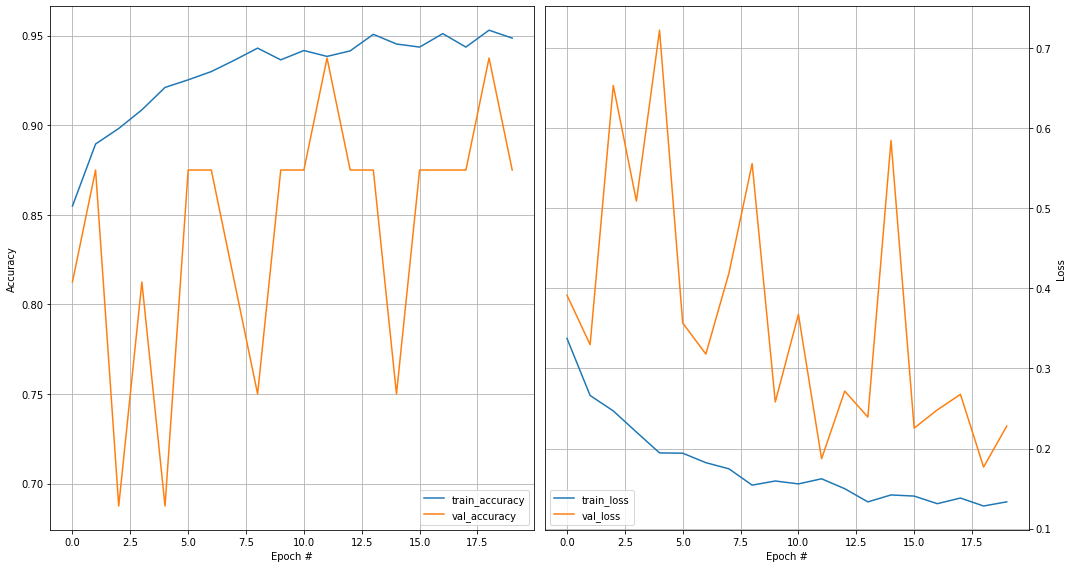

In [0]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharey=False)

ax[0].plot(history.epoch, history.history['accuracy'], label='train_accuracy')
ax[0].plot(history.epoch, history.history['val_accuracy'], label='val_accuracy')
ax[0].legend(loc='lower right')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch #')
ax[0].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

ax[1].plot(history.epoch, history.history['loss'], label='train_loss')
ax[1].plot(history.epoch, history.history['val_loss'], label='val_loss')
ax[1].legend(loc='lower left')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch #')
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")
ax[1].grid()
# ax[0].set_xlim(30,120)
# ax[0].set_ylim(0,.3)

plt.tight_layout();

In [0]:
# try image from other source

url_list = [
            # https://radiopaedia.org/cases/normal-chest-x-ray
            "https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg",
            # https://radiopaedia.org/cases/normal-chest-x-ray-1
            "https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg",
            # https://radiopaedia.org/cases/lobar-pneumonia?lang=us
            "https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg",
            # https://radiopaedia.org/cases/round-pneumonia-8?lang=us
            "https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg", 
            ]

for url in url_list:

  response = requests.get(url)
  # img = Image.open(BytesIO(response.content))
  img = load_img(BytesIO(response.content), target_size=(IMG_WIDTH, IMG_HEIGHT))
  img = img_to_array(img)
  img = np.expand_dims(img, axis=0)

  classes = model.predict(img, batch_size=10)
  print(classes[0][0])
  if classes[0][0]>0.5:
    print(url + " is NORMAL case")
  else:
    print(url + " is PNEUMONIA case")


# uploaded = files.upload()

# for fn in uploaded.keys():

#   path = '/content/' + fn
#   img = load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
#   img = img_to_array(img)
#   img = np.expand_dims(img, axis=0)

  # classes = model.predict(img, batch_size=10)
  # print(classes[0][0])
  # if classes[0][0]>0.5:
  #   print(fn + " is NORMAL case")
  # else:
  #   print(fn + " is PNEUMONIA case")

0.0
https://prod-images-static.radiopaedia.org/images/220869/76052f7902246ff862f52f5d3cd9cd_jumbo.jpg is PNEUMONIA case
0.0
https://prod-images-static.radiopaedia.org/images/8686421/17baee9bfb9018e3d109ec63cb380e_jumbo.jpeg is PNEUMONIA case
1.0
https://prod-images-static.radiopaedia.org/images/27547404/4e1dc09c3abe03a3efb72d494ddb6f_jumbo.jpeg is NORMAL case
0.0
https://prod-images-static.radiopaedia.org/images/2394007/5d72614a0bb470df028956a4d303b0_jumbo.jpg is PNEUMONIA case
